In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import lib
import plotting

In [40]:
from multiprocessing import Pool
import pickle
from collections import defaultdict
import itertools

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
from sklearn.decomposition import PCA

In [6]:
from configparser import ConfigParser
cfg = ConfigParser()
cfg.read("config.cfg")

['config.cfg']

In [7]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # we manually import the notebook submodule as the normal one struggles with jupyterlab
tqdm.pandas() # this enables us to use progress_apply instead of apply

In [8]:
results_prefix = cfg.get("results", "prefix")

sequence_file = os.path.join(cfg.get("directory", "exchange"), results_prefix + "001_clustering.p")
labels_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_labels_readable.p")
results_prefix

'[WIKIDATA_10]'

In [9]:
df = pd.read_pickle(sequence_file)
labels = pd.read_pickle(labels_file)['label'].values
df.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,sequence_readable,user_id,user_name,stat_dist,kmeans_4,kmeans_8
0,False,False,1517,1385,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...","[Revert Item, Break, Create Claim, Break, Crea...",1,Hoo man,"[0.033592832488441825, 0.029154644609674315, 0...",0,3
1,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",100012,Kane 14,"[0.02586206896551723, 0.025862068965517227, 0....",2,1
2,False,False,17,12,"[LABEL_UPDATE, ALIAS_ADD, BREAK, CLAIM_CREATE,...","[Edit Label, Add Item Alias, Break, Create Cla...",1000197,Zaizone,"[0.026205469193709592, 0.07779210211701826, 0....",1,5
3,False,False,91,82,"[SITELINK_UPDATE, BREAK, LABEL_ADD, CLAIM_CREA...","[Edit Sitelink, Break, Add Label, Create Claim...",1001159,Gogo hr,"[0.04118566424353361, 0.03162035177772598, 0.0...",0,0
4,False,False,21,12,"[DESCRIPTION_ADD, BREAK, DESCRIPTION_UPDATE, D...","[Add Description, Break, Edit Description, Add...",1001194,Phylosofo,"[0.08620689655172406, 0.025862068965517255, 0....",1,7


In [10]:
labels

array(['Add Description', 'Add Item Alias', 'Add Label', 'Add Qualifier',
       'Add Reference', 'Add Sitelink', 'Break', 'Create Claim',
       'Create Item', 'Create Property', 'Edit Alias', 'Edit Claim',
       'Edit Claim Value', 'Edit Description', 'Edit Item', 'Edit Label',
       'Edit Qualifier', 'Edit Reference', 'Edit Sitelink', 'Merge Items',
       'Override Item', 'Protect Item', 'Redirect Item', 'Remove Alias',
       'Remove Claim', 'Remove Description', 'Remove Item',
       'Remove Label', 'Remove Qualifier', 'Remove Reference',
       'Remove Sitelink', 'Revert Item'], dtype=object)

In [11]:
num_chunks = cfg.getint("kmeans", "num_temporal_chunks")

def calc_dist_chunked(sequence):
    dist_dict = {}
    chunk_length = len(sequence) // 3
    for chunk_index in range(num_chunks):
        dist, pivot = lib.calc_distribution(labels.copy(), sequence[chunk_index*chunk_length:(chunk_index+1)*chunk_length])
        dist_dict["stat_dist_chunk_{i}".format(i=int(chunk_index))] = np.array(dist)
    return dist_dict

In [12]:
stat_dists = df['sequence_readable'].progress_apply(calc_dist_chunked)

In [14]:
stat_dists[0]

{'stat_dist_chunk_0': array([0.03271298, 0.02827704, 0.03272996, 0.09368902, 0.02588348,
        0.02588348, 0.03102848, 0.1000217 , 0.02588348, 0.02588348,
        0.02622596, 0.0272497 , 0.02588348, 0.02656818, 0.02588348,
        0.02827694, 0.02588348, 0.02588348, 0.02588348, 0.02588348,
        0.02588348, 0.02588348, 0.02588348, 0.02588348, 0.02623006,
        0.02588348, 0.02588348, 0.02588348, 0.02588348, 0.02588348,
        0.02588348, 0.02932041]),
 'stat_dist_chunk_1': array([0.02824608, 0.02687825, 0.02927138, 0.03202873, 0.02585605,
        0.02654063, 0.02995688, 0.13859851, 0.02585605, 0.02585605,
        0.02585605, 0.02585605, 0.02585605, 0.02585605, 0.02585605,
        0.02619806, 0.02585605, 0.02585605, 0.02585605, 0.02585605,
        0.02585605, 0.02688209, 0.02585605, 0.02585605, 0.05767422,
        0.02585605, 0.02585605, 0.02585605, 0.02585605, 0.02585605,
        0.02585605, 0.03474808]),
 'stat_dist_chunk_2': array([0.03988899, 0.03203837, 0.04127846, 0.0258680

In [17]:
df_stat_dists = pd.DataFrame.from_records(stat_dists)
df_stat_dists.head()

,stat_dist_chunk_0,stat_dist_chunk_1,stat_dist_chunk_2
0,"[0.03271298404929652, 0.028277042858212108, 0....","[0.0282460839167121, 0.02687824852974209, 0.02...","[0.039888988479645754, 0.03203837125326975, 0...."
1,"[0.02586206896551726, 0.02586206896551724, 0.0...","[0.02588503236461467, 0.02588503236461472, 0.0...","[0.025885032364614688, 0.02588503236461469, 0...."
2,"[0.027836504580690636, 0.050739957716701874, 0...","[0.02866099417823558, 0.06448723690102993, 0.0...","[0.025862068965517227, 0.025862068965517234, 0..."
3,"[0.042818893056000604, 0.025938600582565308, 0...","[0.0377526753864447, 0.025862068965517265, 0.0...","[0.04342765868267035, 0.04416192004726148, 0.0..."
4,"[0.09522673906662768, 0.02606765482829466, 0.0...","[0.11767772941603226, 0.02541258614435979, 0.0...","[0.05989330746847721, 0.02586206896551724, 0.0..."


In [20]:
df_combined = pd.concat([df, df_stat_dists], axis=1)
df_combined.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,sequence_readable,user_id,user_name,stat_dist,kmeans_4,kmeans_8,stat_dist_chunk_0,stat_dist_chunk_1,stat_dist_chunk_2
0,False,False,1517,1385,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...","[Revert Item, Break, Create Claim, Break, Crea...",1,Hoo man,"[0.033592832488441825, 0.029154644609674315, 0...",0,3,"[0.03271298404929652, 0.028277042858212108, 0....","[0.0282460839167121, 0.02687824852974209, 0.02...","[0.039888988479645754, 0.03203837125326975, 0...."
1,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",100012,Kane 14,"[0.02586206896551723, 0.025862068965517227, 0....",2,1,"[0.02586206896551726, 0.02586206896551724, 0.0...","[0.02588503236461467, 0.02588503236461472, 0.0...","[0.025885032364614688, 0.02588503236461469, 0...."
2,False,False,17,12,"[LABEL_UPDATE, ALIAS_ADD, BREAK, CLAIM_CREATE,...","[Edit Label, Add Item Alias, Break, Create Cla...",1000197,Zaizone,"[0.026205469193709592, 0.07779210211701826, 0....",1,5,"[0.027836504580690636, 0.050739957716701874, 0...","[0.02866099417823558, 0.06448723690102993, 0.0...","[0.025862068965517227, 0.025862068965517234, 0..."
3,False,False,91,82,"[SITELINK_UPDATE, BREAK, LABEL_ADD, CLAIM_CREA...","[Edit Sitelink, Break, Add Label, Create Claim...",1001159,Gogo hr,"[0.04118566424353361, 0.03162035177772598, 0.0...",0,0,"[0.042818893056000604, 0.025938600582565308, 0...","[0.0377526753864447, 0.025862068965517265, 0.0...","[0.04342765868267035, 0.04416192004726148, 0.0..."
4,False,False,21,12,"[DESCRIPTION_ADD, BREAK, DESCRIPTION_UPDATE, D...","[Add Description, Break, Edit Description, Add...",1001194,Phylosofo,"[0.08620689655172406, 0.025862068965517255, 0....",1,7,"[0.09522673906662768, 0.02606765482829466, 0.0...","[0.11767772941603226, 0.02541258614435979, 0.0...","[0.05989330746847721, 0.02586206896551724, 0.0..."


In [45]:
centroids_file = os.path.join(cfg.get("directory", "exchange"), results_prefix + "001_centroids.p")
with open(centroids_file, "rb") as dump_file:
    centroids = pickle.load(dump_file)
        
num_centroids = 4 # change if needed

# quickly fit with the data we already have and one iteration, as we know it already converged.
kmeans = KMeans(n_clusters=num_centroids, init=centroids[num_centroids], max_iter=1)
base_vectors =  np.array([np.array(x) for x in df_combined['stat_dist'].values])
kmeans.fit(base_vectors)

# Check to make sure the centroids did not move. We use isclose to account for rounding errors that start to happen
np.all(np.isclose(centroids[num_centroids][0],kmeans.cluster_centers_[0]))

/home/pkasper/python/Python-3.7.1/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning:

Explicit initial center position passed: performing only one init in k-means instead of n_init=10



True

In [48]:
for chunk_index in tqdm(range(num_chunks)):
    vectors = np.array([np.array(x) for x in df_combined["stat_dist_chunk_{i}".format(i=int(chunk_index))].values])
    df_combined["kmeans_chunk_{i}".format(i=int(chunk_index))] = kmeans.predict(vectors)

In [63]:
# store load trick to avoid redoing the chunked stat dist calc

In [61]:
df_combined.to_pickle(os.path.join(cfg.get("directory", "exchange"), results_prefix + "002_temporal_analysis.p"))

In [13]:
df_combined = pd.read_pickle(os.path.join(cfg.get("directory", "exchange"), results_prefix + "002_temporal_analysis.p"))
df_combined.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,sequence_readable,user_id,user_name,stat_dist,kmeans_4,kmeans_8,stat_dist_chunk_0,stat_dist_chunk_1,stat_dist_chunk_2,kmeans_chunk_0,kmeans_chunk_1,kmeans_chunk_2
0,False,False,1517,1385,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...","[Revert Item, Break, Create Claim, Break, Crea...",1,Hoo man,"[0.033592832488441825, 0.029154644609674315, 0...",0,3,"[0.03271298404929652, 0.028277042858212108, 0....","[0.0282460839167121, 0.02687824852974209, 0.02...","[0.039888988479645754, 0.03203837125326975, 0....",0,0,1
1,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",100012,Kane 14,"[0.02586206896551723, 0.025862068965517227, 0....",2,1,"[0.02586206896551726, 0.02586206896551724, 0.0...","[0.02588503236461467, 0.02588503236461472, 0.0...","[0.025885032364614688, 0.02588503236461469, 0....",2,2,2
2,False,False,17,12,"[LABEL_UPDATE, ALIAS_ADD, BREAK, CLAIM_CREATE,...","[Edit Label, Add Item Alias, Break, Create Cla...",1000197,Zaizone,"[0.026205469193709592, 0.07779210211701826, 0....",1,5,"[0.027836504580690636, 0.050739957716701874, 0...","[0.02866099417823558, 0.06448723690102993, 0.0...","[0.025862068965517227, 0.025862068965517234, 0...",1,1,1
3,False,False,91,82,"[SITELINK_UPDATE, BREAK, LABEL_ADD, CLAIM_CREA...","[Edit Sitelink, Break, Add Label, Create Claim...",1001159,Gogo hr,"[0.04118566424353361, 0.03162035177772598, 0.0...",0,0,"[0.042818893056000604, 0.025938600582565308, 0...","[0.0377526753864447, 0.025862068965517265, 0.0...","[0.04342765868267035, 0.04416192004726148, 0.0...",0,0,0
4,False,False,21,12,"[DESCRIPTION_ADD, BREAK, DESCRIPTION_UPDATE, D...","[Add Description, Break, Edit Description, Add...",1001194,Phylosofo,"[0.08620689655172406, 0.025862068965517255, 0....",1,7,"[0.09522673906662768, 0.02606765482829466, 0.0...","[0.11767772941603226, 0.02541258614435979, 0.0...","[0.05989330746847721, 0.02586206896551724, 0.0...",1,1,1


In [89]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
init_notebook_mode(connected=True)
import colormap

In [124]:
labels = ["Claim Expert", "Description Expert", "Sitelink Creator", "Sitelink Editor"] * num_chunks
colors = [colormap.get_static_plotly(x, alpha=1) for x in range(num_centroids)] * num_chunks
colors_alpha = [colormap.get_static_plotly(x, alpha=0.5) for x in range(num_centroids)] * num_chunks

In [125]:
sources = []
targets = []
counts = []
for state_index in range(num_chunks-1):
    for cl_from, cl_to in itertools.product(np.arange(num_centroids), repeat=2):
        sources.append(cl_from + (num_centroids * state_index))
        targets.append(cl_to + (num_centroids * (state_index+1)))
        counts.append(len(df_combined.loc[(df_combined["kmeans_chunk_{si}".format(si=state_index)] == cl_from) & (df_combined["kmeans_chunk_{si}".format(si=state_index+1)] == cl_to)]))   

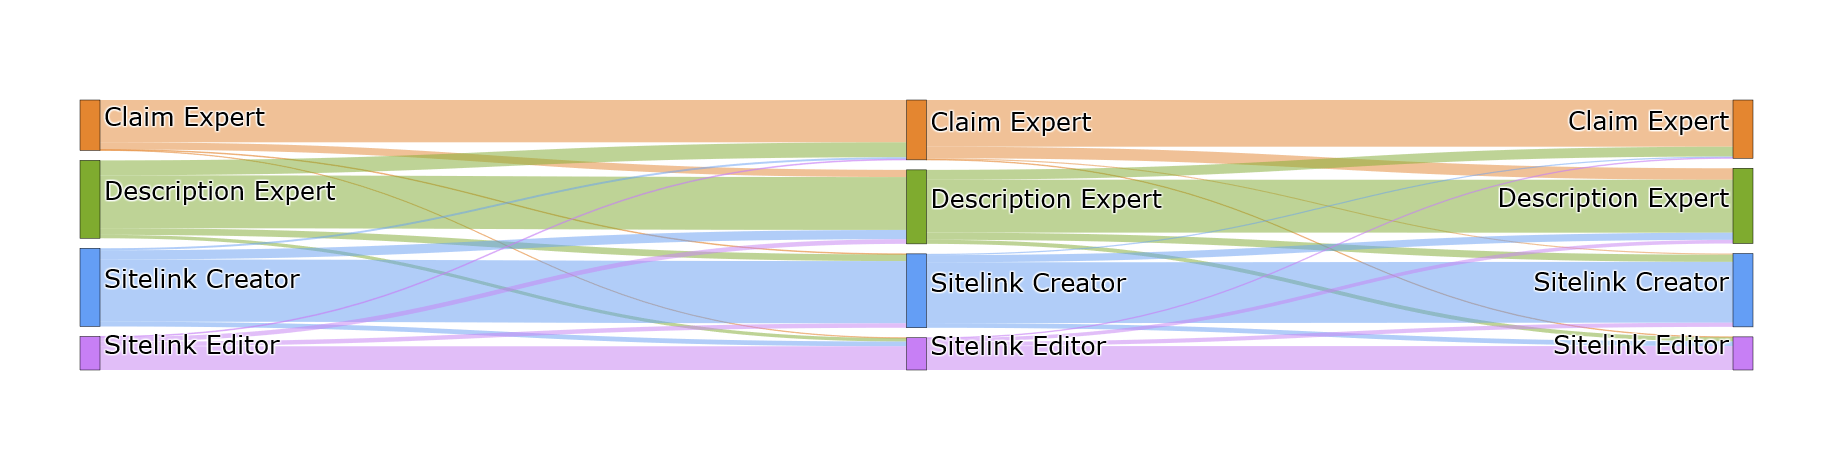

In [135]:
data = dict(
    type='sankey',
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(
          color = "black",
          width = 0.5
      ),
      label = labels,
      color = colors
    ),
    link = dict(
        source = sources,
        target = targets,
        value = counts,
        color = [colors_alpha[x] for x in sources]
  ))

layout =  dict(
    font = dict(
      size = 25
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = dict(data=[data], layout=layout)
store_path = os.path.join(cfg.get("directory", "results"), results_prefix + "sankey[{n}]centroids".format(n=num_centroids)) + ".html"
plot(fig, filename=store_path, validate=False)
iplot(fig, validate=False)

In [136]:
store_path

'data/results/[WIKIDATA_10]sankey[4]centroids.html'